# <군집별 특성 기반 타깃 선정 및 맞춤 전략 설계>
### : 방문객은 많지만 재방문율이 낮은 나라 - 조현서

근데, 클러스터링 이슈로 재방문율 높은데 방문객은 적당히 오는,, 그런 군집을 맡게됨(cluster4)

---

In [44]:
import os 
print(os.getcwd())
os.chdir("/Users/ari/Desktop/데이터관광공모전")
print(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'  # 맥북 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

/Users/ari/Desktop/데이터관광공모전
/Users/ari/Desktop/데이터관광공모전


## 1. 군집화 요약

### 인구 데이터 병합

In [45]:
df = pd.read_csv('./data/traveler_data.csv', encoding='cp949')

country_map = {
    1: "중국", 2: "일본", 3: "대만", 4: "미국", 5: "홍콩",
    6: "태국", 7: "베트남", 8: "말레이시아", 9: "필리핀", 10: "싱가포르",
    11: "러시아", 12: "중동", 13: "인도네시아", 14: "캐나다", 15: "호주",
    16: "영국", 17: "몽골", 18: "독일", 19: "프랑스", 20: "인도", 97: "기타"
}
df["국가"] = df["D_NAT"].map(country_map)


# 방문객 수 계산 (weight 합)
size = df.groupby("국가")[["weight"]].sum().rename(columns={"weight": "방문객수"})
size.drop('기타', axis=0, inplace=True) # 기타는 정확한 나라를 모르기 때문에 제거
size

,방문객수
국가,
대만,1325254.46
독일,129618.79
러시아,140431.18
말레이시아,251390.17
몽골,125476.79
미국,1067296.15
베트남,423794.18
싱가포르,320685.75
영국,123436.89


In [46]:
# 인구 데이터프레임: 국가명과 인구수
pop = pd.read_csv('./data/외교부_국가_지역 검색_인구수_스크랩.csv')
pop = pop.set_index("국가명")
pop

,인구수(명)
국가명,
대만,23410000
독일,84600000
러시아,145630000
말레이시아,34100000
몽골,3500000
미국,340110000
베트남,101300000
싱가포르,6040000
영국,67020000


In [47]:
# 국가 기준으로 병합
merged = size.join(pop)

# 방문객 비율 (%) 계산
merged["방문객비율"] = (merged["방문객수"] / merged["인구수(명)"]) * 100

merged

,방문객수,인구수(명),방문객비율
국가,,,
대만,1325254.46,23410000,5.661061
독일,129618.79,84600000,0.153214
러시아,140431.18,145630000,0.096430
말레이시아,251390.17,34100000,0.737215
몽골,125476.79,3500000,3.585051
미국,1067296.15,340110000,0.313809
베트남,423794.18,101300000,0.418356
싱가포르,320685.75,6040000,5.309367
영국,123436.89,67020000,0.184179


### 재방문율 변수 생성

In [48]:
repeat = df.groupby("국가").apply(
    lambda x: ((x["D_NUM"] >= 2) * x["weight"]).sum() / x["weight"].sum() * 100
).round(1)
repeat.drop('기타', axis=0, inplace=True)

features = pd.concat([merged["방문객비율"], repeat.rename("재방문율")], axis=1)
features

,방문객비율,재방문율
국가,,
대만,5.661061,56.5
독일,0.153214,33.1
러시아,0.096430,47.2
말레이시아,0.737215,45.1
몽골,3.585051,64.8
미국,0.313809,42.1
베트남,0.418356,34.9
싱가포르,5.309367,59.2
영국,0.184179,40.2


### 표준화

In [49]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

### Hierarchical Clustering

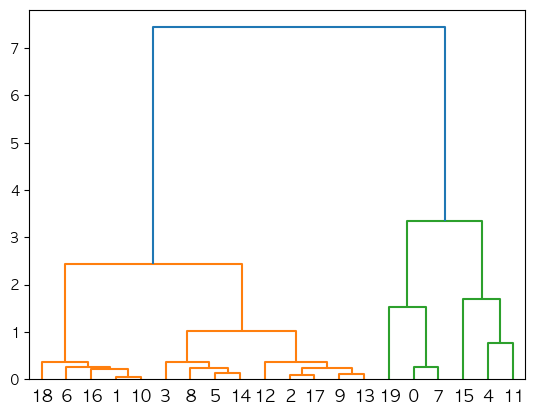

In [50]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Z = linkage(X_scaled, method='ward')
dendrogram(Z)
# 군집 할당
features['Hcluster'] = fcluster(Z, t=4, criterion='maxclust')

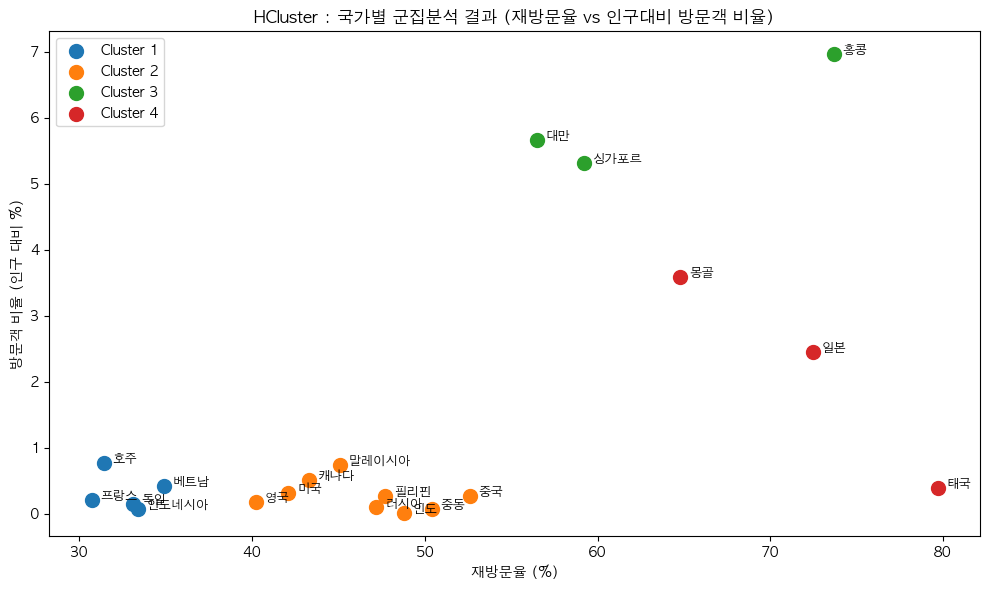

In [51]:
# 시각화
plt.figure(figsize=(10,6))
for c in range(1,5):
    cluster_countries = features[features["Hcluster"]==c].index
    plt.scatter(
        features.loc[cluster_countries, "재방문율"],
        features.loc[cluster_countries, "방문객비율"],
        label=f"Cluster {c}",
        s=100
    )
    for name in cluster_countries:
        plt.text(
            features.loc[name,"재방문율"]+0.5,
            features.loc[name,"방문객비율"],
            name,
            fontsize=9
        )

plt.xlabel("재방문율 (%)")
plt.ylabel("방문객 비율 (인구 대비 %)")
plt.title("HCluster : 국가별 군집분석 결과 (재방문율 vs 인구대비 방문객 비율)")
plt.legend()
plt.tight_layout()
plt.show()

> 해석  
1. *Cluster 1 (호주, 독일, 인도네시아 등)*
    - 낮은 재방문율 (30~35%). 낮은 방문객 비율
    - 해석: 아직 진입 초기 단계
    - 전략: 브랜드 인지도 제고 중심의 시장 진출 전략, 장기 여행/학생 등 niche market 접근

2. *Cluster 2 (중국, 러시아, 미국, 말레이시아 등)*
    - 중간 수준 재방문율 (40~53%). 방문객 비율은 낮음 (0.1~0.7%)
    - 해석: 잠재 수요가 큰 시장
    - 전략: 방문 장벽 제거 (비자, 항공편 등), 한류 콘텐츠와 결합한 마케팅 필요

3. *Cluster 3 (홍콩, 싱가포르, 대만)*
    - 인구 대비 방문 비율이 매우 높음 (5~7%). 재방문율도 55~73%로 높음
    - 해석: 시장 침투율도 높고, 반복 방문율도 높음
    - 전략: VIP 및 프리미엄 고객 타깃, 짧고 빈번한 여행을 위한 맞춤 콘텐츠 (단기 여행객)

4. ⭐️ Cluster 4 (태국, 일본, 몽골) ⭐️ --> 분석 가볼까
    - 재방문율이 매우 높음 (70% 이상). 방문객 비율은 고르게 분포 (몽골 > 일본 > 태국)
    - 해석: 충성도 높은 시장 → 핵심 전략 타깃
    - 전략: 기존 관광 콘텐츠의 고도화. 지역관광 확산 유도 (서울 집중 완화)

### 근데!!! 참고할 것은 아래 두 통계


▶ 국가별 방한목적 비율 (선택 국가만)
목적     교육   기타  사업/전문활동  여가/휴식  친구/친지 방문
국가                                      
몽골    8.7  3.9     29.7   29.2      28.4
싱가포르  1.2  0.3     17.9   76.0       4.6
대만    1.3  0.2      8.4   86.4       3.7
일본    0.9  0.5     12.7   74.9      11.0


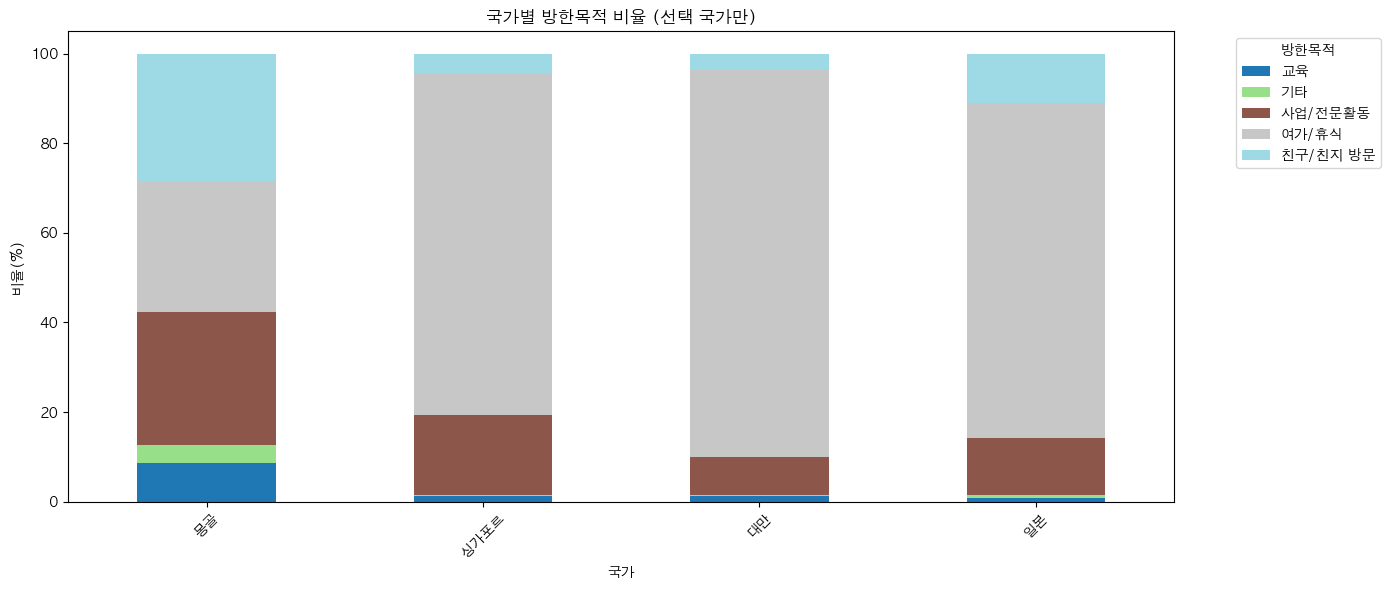

In [52]:
# 2. 싱가폴, 대만, 몽골, 일본 주요 방한목적
moks = df.groupby(["국가", "D_MOK"])["weight"].sum().reset_index()
moks_total = moks.groupby("국가")["weight"].sum().reset_index().rename(columns={"weight":"총합"})
moks_merged = pd.merge(moks, moks_total, on="국가")
moks_merged["비율(%)"] = (moks_merged["weight"] / moks_merged["총합"] * 100).round(1)

# 방한목적 코드 매핑
mok_map = {1:"여가/휴식", 2:"친구/친지 방문", 3:"사업/전문활동", 4:"교육", 5:"기타"}
moks_merged["목적"] = moks_merged["D_MOK"].map(mok_map)

pivot_mok = moks_merged.pivot(index="국가", columns="목적", values="비율(%)").fillna(0)
# 원하는 국가만 선택
selected_countries = ["몽골", "싱가포르", "대만", "일본"]

print("\n▶ 국가별 방한목적 비율 (선택 국가만)")
print(pivot_mok.loc[selected_countries])

# 시각화도 선택 국가만
pivot_mok.loc[selected_countries].plot(
    kind="bar", stacked=True, figsize=(14,6), colormap="tab20"
)
plt.title("국가별 방한목적 비율 (선택 국가만)")
plt.ylabel("비율(%)")
plt.xlabel("국가")
plt.xticks(rotation=45)
plt.legend(title="방한목적", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


▶ 국가별 방한횟수 비율 (선택 국가만)
방한횟수    1회    2회    3회  4회 이상
국가                           
일본    27.5  15.8  12.0   44.7
몽골    35.2  20.9   8.5   35.5
싱가포르  40.8  21.3  15.4   22.6
대만    43.5  25.1  11.7   19.7


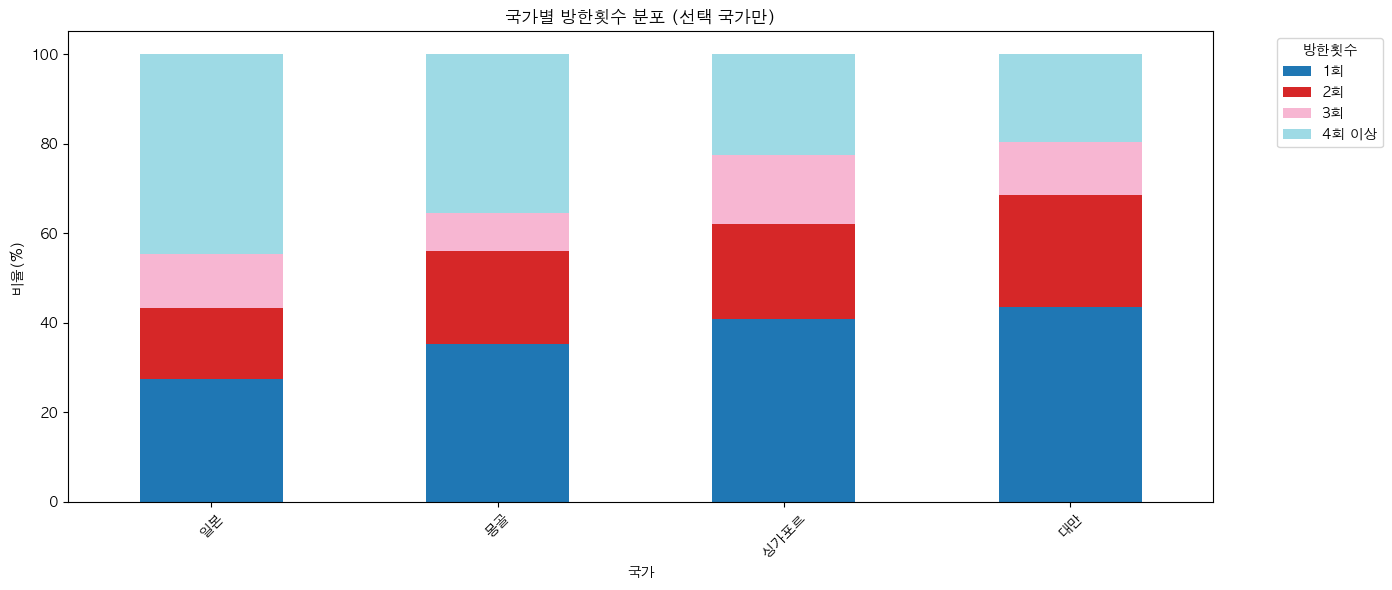

In [53]:
# 1. D_NUM별(방문횟수) 비율 계산
visits = df.groupby(["국가", "D_NUM"])["weight"].sum().reset_index()

# 2. 국가별 총합 구해서 merge
visits_total = visits.groupby("국가")["weight"].sum().reset_index().rename(columns={"weight": "총합"})
visits_merged = pd.merge(visits, visits_total, on="국가")

# 3. 비율 계산
visits_merged["비율(%)"] = (visits_merged["weight"] / visits_merged["총합"] * 100).round(1)

# 4. 횟수 코드 매핑
visit_map = {1: "1회", 2: "2회", 3: "3회", 4: "4회 이상"}
visits_merged["방한횟수"] = visits_merged["D_NUM"].map(visit_map)

# 5. 피벗 테이블로 변환
pivot_visit = visits_merged.pivot(index="국가", columns="방한횟수", values="비율(%)").fillna(0)

# 6. 선택 국가 필터링
selected_countries = [ "일본", "몽골", "싱가포르", "대만"]
print("\n▶ 국가별 방한횟수 비율 (선택 국가만)")
print(pivot_visit.loc[selected_countries])

# 시각화
pivot_visit.loc[selected_countries].plot(
    kind="bar", stacked=True, figsize=(14,6), colormap="tab20"
)
plt.title("국가별 방한횟수 분포 (선택 국가만)")
plt.ylabel("비율(%)")
plt.xlabel("국가")
plt.xticks(rotation=45)
plt.legend(title="방한횟수", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



몽골은 방한 목적이 '여가', '친지방문', '사업' 이 고루 분배되어 있다는 점에서 일본(여가중심), 대만(여가중심), 싱가포르(여가중심)와 전부 방한 목적의 결이 다르다.  
- 목적 측면에서 몽골은 일반 / 싱가포르, 대만 그 어느 군집에 끼기에도 애매함  
--> 따로 군집을 나눌까? 

### -> 일단 H-cluster 채용했다고 가정하고 분석 시작하자
---

# 군집 별 비율 계산 및 시각화
## 1. 여행형태(TYP)

우산 나라별 관광객 수를 보자

In [54]:
df_cluster4 = df[df["국가"].isin(cluster4_countries)]
df_cluster4.groupby("국가")["weight"].sum()

국가
몽골     125476.79
일본    3017004.10
태국     274186.70
Name: weight, dtype: float64

### 일본이 압도적으로 많아서 군집별로 통계를 내는 경우, 거의 일본으로 쏠림 현상이 있겠다

여행형태      Air-tel  개별여행  단체여행
Hcluster                     
1.0           1.2  78.7  20.2
2.0           0.6  89.0  10.4
3.0           2.2  70.1  27.7
4.0          28.3  67.8   4.0


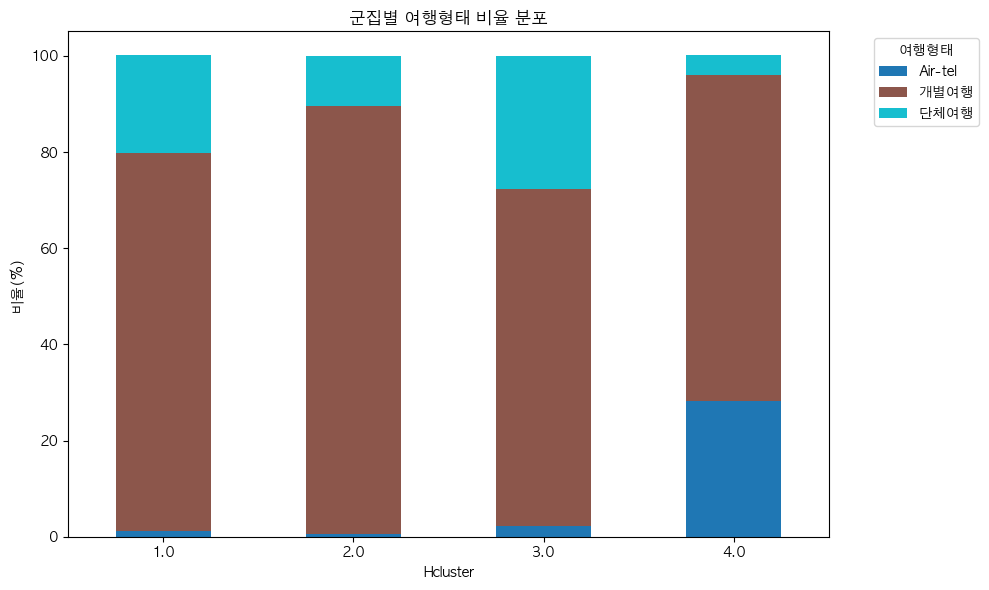

In [55]:
# 군집 정보 합치기
df_clustered = df.copy()
df_clustered["Hcluster"] = df["국가"].map(features["Hcluster"])

# 1. 여행형태별 비율 계산
typ_counts = df_clustered.groupby(["Hcluster", "TYP"])["weight"].sum().reset_index()
typ_total = typ_counts.groupby("Hcluster")["weight"].sum().reset_index().rename(columns={"weight": "총합"})
typ_merged = pd.merge(typ_counts, typ_total, on="Hcluster")
typ_merged["비율(%)"] = (typ_merged["weight"] / typ_merged["총합"] * 100).round(1)

# 코드값 매핑
typ_map = {1: "개별여행", 2: "Air-tel", 3: "단체여행"}
typ_merged["여행형태"] = typ_merged["TYP"].map(typ_map)

# 피벗 테이블로 변환
pivot_typ = typ_merged.pivot(index="Hcluster", columns="여행형태", values="비율(%)").fillna(0)
print(pivot_typ)

pivot_typ.plot(kind="bar", stacked=True, figsize=(10,6), colormap="tab10")
plt.title("군집별 여행형태 비율 분포")
plt.ylabel("비율(%)")
plt.xlabel("Hcluster")
plt.xticks(rotation=0)
plt.legend(title="여행형태", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


> 해석  

군집4의 경우만 독보적으로 Air-tel의 여행 형태가 많다.

**Air-tel 여행형태란?**  
에어텔은 '에어(Air)'와 '호텔(Hotel)'의 합성어로, 항공권과 숙박을 함께 묶어 판매하는 여행 상품 형태. 즉, 항공권과 호텔 예약이 한 번에 가능한 패키지 여행과 유사하지만, 패키지처럼 일정이 정해져 있는 것이 아니라 항공과 숙소만 제공되고 나머지 여행 일정은 자유롭게 계획할 수 있다는 특징이 있음. 
- 즉, 몽골, 일본, 태국은 항공권과 숙박을 묶어서 한번에 구매하는 경우가 많고
- 패키지여행보다는 자유로운, 맞춤형 여행을 선호히며
- 단체여행보다는 항공과 숙소만 해결하고 나머지 일정을 자유롭게 즐기고자 하는 수요가 많다  

-> 아무래도 거리가 가깝다보니, 한국에 대한 정보도 많고, 굳이 패키지/단체로 시간을 낭비하지 않고자 하는 것 같다. 이 국가들은 이미 한국에 대한 정보가 많다는 점을 유의하면서 분석해봐야겠다.   


(나였어도 익숙한 일본이나 태국, 홍콩, 베트남 등을 간다고 하면  패키지 여행은 안갈 것 같음)

---

## 2. 방한 목적(Q1)


▶ Cluster 4 국가 주요 방문목적 비율
       방문목적  비율(%)
0  여가/위락/휴식   71.5
1  친구/친지 방문   12.9
2  사업/전문 활동   13.4
3        교육    1.7
4        기타    0.6


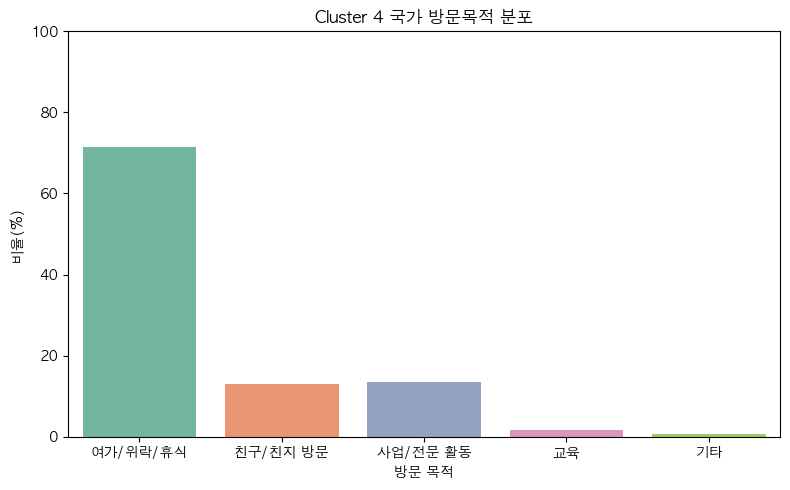

In [56]:
# 1. Cluster 4 국가 필터링
cluster4_countries = features[features["Hcluster"] == 4].index.tolist()
df_cluster4 = df[df["국가"].isin(cluster4_countries)].copy()

# 2. 방문 목적별 가중합 계산
q1_counts = df_cluster4.groupby("Q1")["weight"].sum().reset_index()
total_weight = q1_counts["weight"].sum()
q1_counts["비율(%)"] = (q1_counts["weight"] / total_weight * 100).round(1)

# 3. 코드 매핑
q1_map = {
    1: "여가/위락/휴식",
    2: "친구/친지 방문",
    3: "사업/전문 활동",
    4: "교육",
    5: "기타"
}
q1_counts["방문목적"] = q1_counts["Q1"].map(q1_map)

# 4. 출력
print("\n▶ Cluster 4 국가 주요 방문목적 비율")
print(q1_counts[["방문목적", "비율(%)"]])

plt.figure(figsize=(8,5))
sns.barplot(data=q1_counts, x="방문목적", y="비율(%)", palette="Set2")
plt.title("Cluster 4 국가 방문목적 분포")
plt.ylabel("비율(%)")
plt.xlabel("방문 목적")
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


> 해석

여가/위락/휴식 비율이 압도적으로 높은 비중 (70%) 

- 관광 자율성/자유여행으로 여가를 즐기기 위해 방한을 하는 것 같다. 이 군집은 자유를 보장하면서 관광 활성화에 힘써야 함. 여가 외 목적이 상대적으로 낮으므로, "문화, 레저 콘텐츠" 강화에 반응할 가능성↑. 반복 방문을 유도할 수 있는 관광 패턴 최적화 전략이 유효하낟.
- 이에 더해, 친지 방문, 사업활동도 비등비등하게 수요가 존재하므로, 이들의 주요 활동지를 통계내서 근방에서 쉽게 소비할 수 있도록 or 추가 숙박을 유도해야 한다.


▶ Cluster 4 국가별 방문목적 비율
방문목적   교육   기타  사업/전문 활동  여가/위락/휴식  친구/친지 방문
국가                                          
몽골    8.7  3.9      29.7      29.2      28.4
일본    0.9  0.5      12.7      74.9      11.0
태국    8.2  0.0      13.2      53.0      25.6


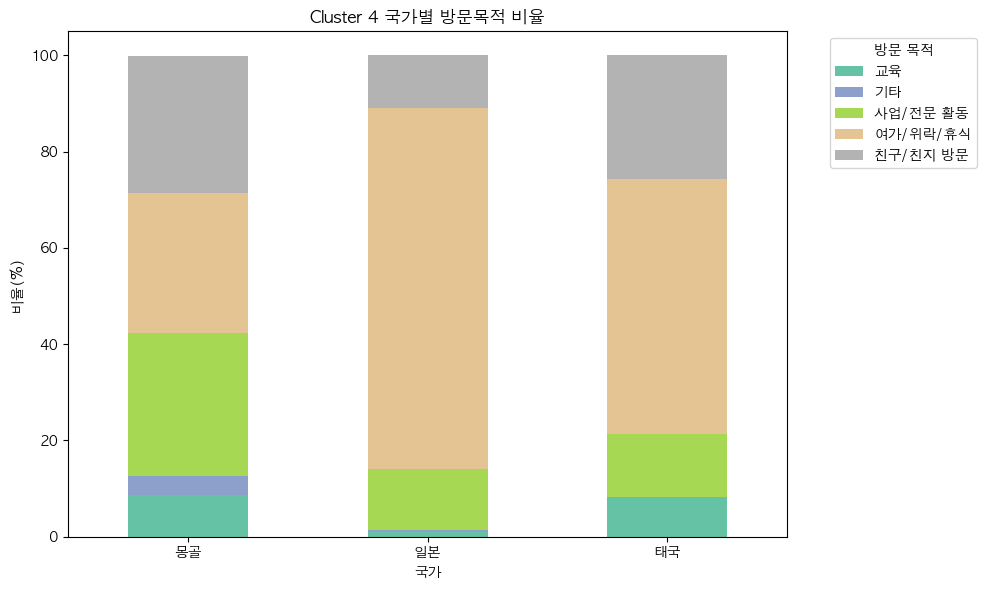

In [57]:
# 방문 목적별 가중합 계산(나라별)
q1_by_country = df_cluster4.groupby(["국가", "Q1"])["weight"].sum().reset_index()

# 국가별 총합
total_by_country = q1_by_country.groupby("국가")["weight"].sum().reset_index().rename(columns={"weight": "총합"})
q1_merged = pd.merge(q1_by_country, total_by_country, on="국가")
q1_merged["비율(%)"] = (q1_merged["weight"] / q1_merged["총합"] * 100).round(1)

q1_merged["방문목적"] = q1_merged["Q1"].map(q1_map)

# 피벗 테이블
pivot_q1 = q1_merged.pivot(index="국가", columns="방문목적", values="비율(%)").fillna(0)
print("\n▶ Cluster 4 국가별 방문목적 비율")
print(pivot_q1)

# Stacked bar chart
pivot_q1.plot(
    kind="bar",
    stacked=True,
    figsize=(10,6),
    colormap="Set2"
)
plt.title("Cluster 4 국가별 방문목적 비율")
plt.ylabel("비율(%)")
plt.xlabel("국가")
plt.xticks(rotation=0)
plt.legend(title="방문 목적", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

> 해석  

나라별로 특징이 있나 해서 여가/친지방문/사업 등의 방문목적을 시각화해봄   
나라 배열 순서는 몽골 < 일본 < 태국 으로 재방문율이 높은데

- 의외로 태국이 친지방문 수요가 꽤나 있음. (물론 여가중심이긴 함)
    - 일회성인 '여가' + 반복성인 '친지방문'이 합쳐져서 압도적인 재방문율을 나타내는 것 같음
- 일본은 완전히 여가중심
- 몽골은 재밌는게, 여가/친지방문/사업이 고루 분배되어 있음.
    - 처음에는 이게 복수응답이라서, 대부분 친지방문이나 사업하러 왔다가 여가도 하니까 고르게 분배됐나보다 했는데, 그게 아니고 찐으로 한국 방문 목적이 여가/친지/사업으로 균일하게 나눠짐




▶ Cluster 4 국가 한국 방문 전후 경로 비율 (복수응답)
       방문형태  비율(%)
0    한국만 방문   98.4
1  직전 타국 방문    1.4
2  직후 타국 방문    0.4
3  전후 모두 방문    1.6


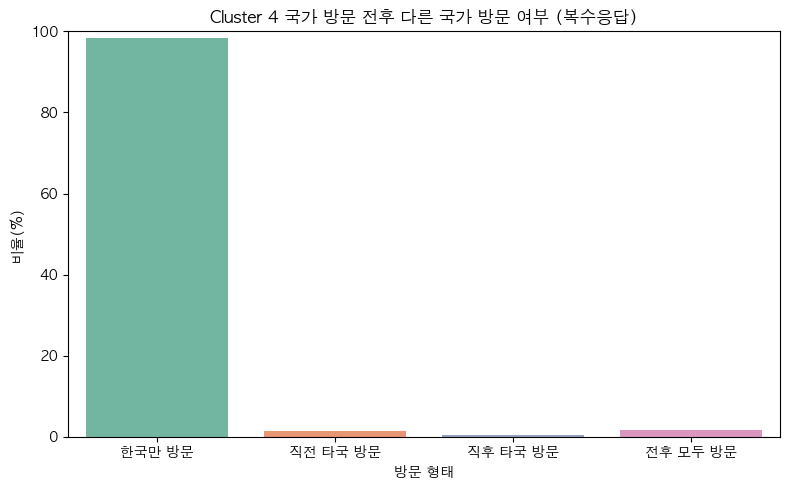

In [58]:
# ZQ2_31~34 열 추출 및 병합
zq_cols = ["ZQ2_31", "ZQ2_32", "ZQ2_33", "ZQ2_34"]
df_zq = df_cluster4[["weight"] + zq_cols].copy()

# melt해서 세로로 합치기
zq_melted = df_zq.melt(id_vars="weight", value_name="경로코드").dropna()

# 코드별 가중합 및 비율
zq_counts = zq_melted.groupby("경로코드")["weight"].sum().reset_index()
total_weight = df_cluster4["weight"].sum()
zq_counts["비율(%)"] = (zq_counts["weight"] / total_weight * 100).round(1)

# 코드명 매핑
zq_map = {
    1: "한국만 방문",
    2: "직전 타국 방문",
    3: "직후 타국 방문",
    4: "전후 모두 방문"
}
zq_counts["방문형태"] = zq_counts["경로코드"].map(zq_map)

# 출력
print("\n▶ Cluster 4 국가 한국 방문 전후 경로 비율 (복수응답)")
print(zq_counts[["방문형태", "비율(%)"]])

plt.figure(figsize=(8,5))
sns.barplot(data=zq_counts, x="방문형태", y="비율(%)", palette="Set2")
plt.title("Cluster 4 국가 방문 전후 다른 국가 방문 여부 (복수응답)")
plt.ylabel("비율(%)")
plt.xlabel("방문 형태")
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()



> 해석  

압도적 다수가 한국만 단독으로 방문하는 패턴을 보인다. 다국 연계여행 성향은 낮다  

- "단독 한국 방문 중심 여가형 시장"으로 점점 좁혀진다
- 즉, 이들은 한국 자체의 매력으로 방문한다는 것을 의미한다
- 이들이 매력을 느낀 포인트를 강화하거나 연계하여 새로운 관광 포인트를 만들 수도 있다
- 이들 군집은 다국연계보다 직한, 단독 노선 강화가 필요하고, 방문이 더 용이하도록 혜택을 주거나
-  체류형 관광 콘텐츠에 대한 강화가 적합하다.

-> 이건 나라별로 할 필요 없을듯

---

## 3. 방한 관심 계기(Q2_1a1~3)

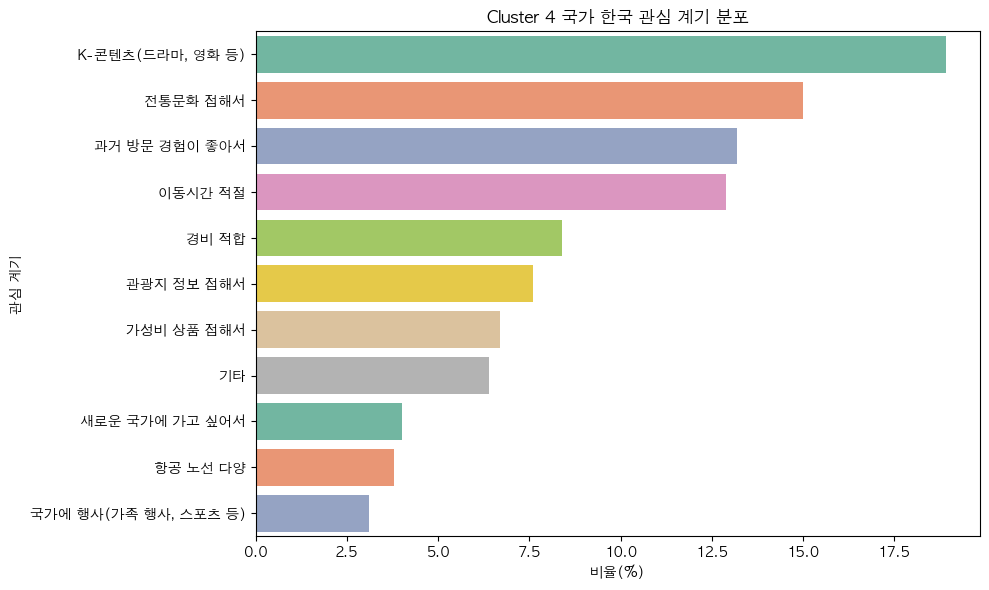

In [59]:
# 한국 관심 계기 변수: Q1_1a1 ~ Q1_1a3 복수응답 변수 합치기
cols = ["Q1_1a1", "Q1_1a2", "Q1_1a3"]
melted = df_cluster4[cols + ["weight"]].melt(id_vars="weight",value_vars=cols, value_name="code").dropna(subset=['code'])
weighted = melted.groupby("code")["weight"].sum().reset_index()

# 코드별 가중합 집계
q_reason = melted.groupby("code")["weight"].sum().reset_index()
q_reason["비율(%)"] = (q_reason["weight"] / q_reason["weight"].sum() * 100).round(1)

# 코드 매핑
reason_map = {
    1: "새로운 국가에 가고 싶어서",
    2: "과거 방문 경험이 좋아서",
    3: "국가에 행사(가족 행사, 스포츠 등)",
    4: "경비 적합",
    5: "이동시간 적절",
    6: "항공 노선 다양",
    7: "K-콘텐츠(드라마, 영화 등)",
    8: "전통문화 접해서",
    9: "관광지 정보 접해서",
    10: "가성비 상품 접해서",
    11: "기타"
}

# 관심사 항목 매핑
q_reason["관심계기"] = q_reason["code"].map(reason_map)

# 시각화
plt.figure(figsize=(10,6))
sns.barplot(data=q_reason.sort_values("비율(%)", ascending=False), y="관심계기", x="비율(%)", palette="Set2")
plt.title("Cluster 4 국가 한국 관심 계기 분포")
plt.xlabel("비율(%)")
plt.ylabel("관심 계기")
plt.tight_layout()
plt.show()

> 전체 군집 해석  

한국이라는 나라에 대한 관심이 생긴 계기는 
- 드라마, 영화 등 K-콘텐츠
- 한국 전통문화
- 과거 방문
- 이동시간 적절  

순서로 유의미한 유입 계기가 있었다.  

아무래도 가성비/경비 여행 이런 것 보다는, 순수하게 콘텐츠, 지리적 가까움 등을 통해 자연스럽게 한국이라는 나라를 접하고, 이가 방문으로 이어진 것 같다.  

### 예상 외 였던 것은  
- 한국의 경우에는, 국가의 행사나 축제 같은 것이 관심계기에 잘 해당하지 않는다는 점이다  

-> 해당 군집은 **여가 목적으로 방한**하는 것이 크고, **지리적으로도 가까워서** 충분히 국가 행사나 축제등이 여행 유입이 될 수도 있을텐데, (삿포로 눈축제처럼) 가장 비율이 적다는건, 그만큼 **축제나 행사의 퀄리티가 좋지 않음**을 의미한다. 국가 행사 퀄리티 개선에 대한 투자가 필요.

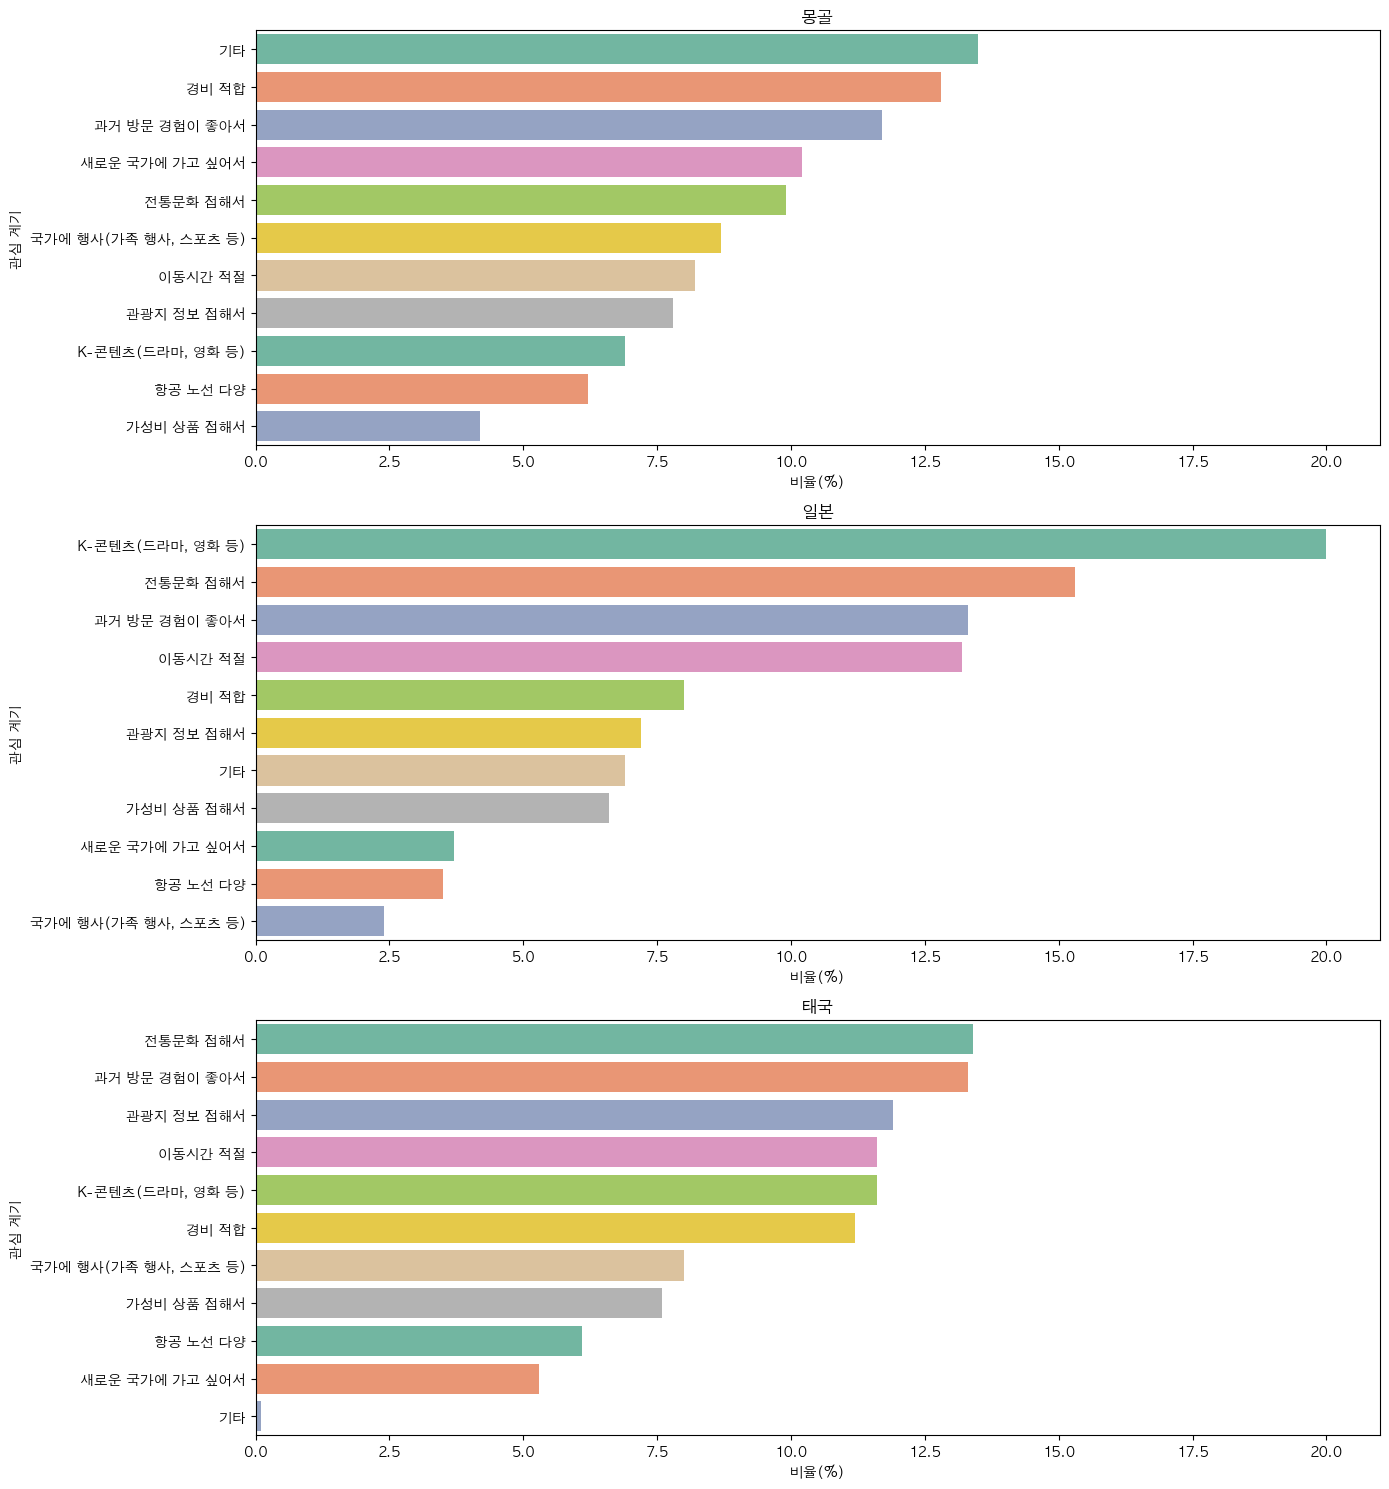

In [60]:
# 군집 내 나라별로 동일하게 진행
plt.figure(figsize=(14, 5 * len(cluster4_countries)))

for i, country in enumerate(cluster4_countries):
    df_country = df_cluster4[df_cluster4["국가"] == country].copy()
    melted = df_country[cols + ["weight"]].melt(id_vars="weight", value_vars=cols, value_name="code").dropna(subset=['code'])
    weighted = melted.groupby("code")["weight"].sum().reset_index()
    total = weighted["weight"].sum()
    weighted["비율(%)"] = (weighted["weight"] / total * 100).round(1)
    weighted["관심계기"] = weighted["code"].map(reason_map)

    # 서브플롯
    plt.subplot(len(cluster4_countries), 1, i + 1)
    sns.barplot(data=weighted.sort_values("비율(%)", ascending=False), y="관심계기", x="비율(%)", palette="Set2")
    plt.title(f"{country}")
    plt.xlabel("비율(%)")
    plt.ylabel("관심 계기")
    plt.xlim(0, 21)

plt.tight_layout()
plt.show()


> 나라별 해석  

군집 내의 나라별로 시각화 한 결과,
- ***몽골***은 흥미롭게도 '기타'가 가장 많다. 확실히 몽골은 여행 목적이 완전히 여가 중심도 아니고, '몽탄신도시'라는 말이 있을 만큼 한국 기업들의 몽골 진출이 활발하다. 뿐만 아니라, 몽골의 경제적인 이유로 인한 지속적인 인적 교류 덕분에, 몽골 청년들이 한국에 대해 갖고 있는 인식 또한 무척 친근하다. 이러한 과정 덕분에 한국에 대한 좋은 인식을 가지게 되었고 삶에 밀접할 정도로 한국과 닿아 있다고 분석된다. 
- ***일본***은 거의 여가 중심
- ***태국***은 K-콘텐츠보다 전통문화에 대한 비율이 더 높다. 또한, 경비적인 부분에서도 일본보단 부담이 덜되는 것으로 보인다. 

---

## 4. 한국 관련 정보 수집 경로(Q4a1~4a_dk)

In [61]:
df_cluster4["Q4a_dk"].value_counts(dropna=False)

Q4a_dk
NaN    2911
9.0     163
Name: count, dtype: int64

Q4a_dk는 '정보를 얻지 않았다(9번)' 선택지 전용 -> 복수응답에서 제외

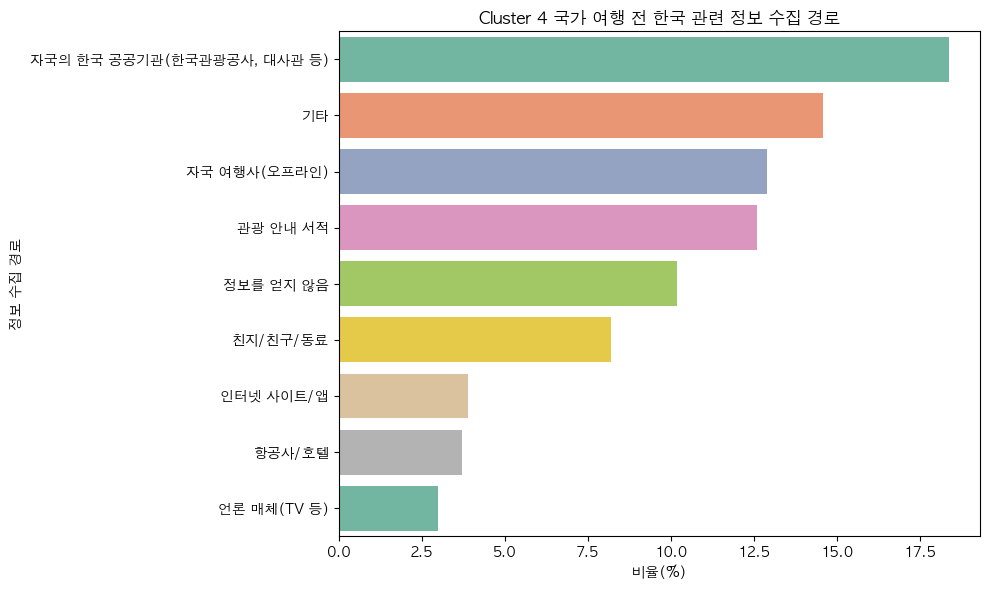

In [62]:
# 기본 변수
info_cols = ["Q4a1", "Q4a2", "Q4a3"]
df_temp = df_cluster4.copy()

# 1. 복수응답 melt (Q4a1~3)
melted = df_cluster4[cols + ["weight"]].melt(id_vars="weight", value_vars=cols, value_name="code").dropna()

# 2. Q4a_dk == 9(정보를 얻지 않은) 경우는 별도로 코드 9 부여
dk_df = df_cluster4[df_cluster4["Q4a_dk"] == 9][["weight"]].copy()
dk_df["code"] = 9

# 3. 두 데이터 합치기
combined = pd.concat([melted[["code", "weight"]], dk_df], ignore_index=True)

# 4. 가중합 및 비율 계산
weighted = combined.groupby("code")["weight"].sum().reset_index()
weighted["비율(%)"] = (weighted["weight"] / weighted["weight"].sum() * 100).round(1)

# 5. 매핑
source_map = {
    1: "인터넷 사이트/앱",
    2: "자국 여행사(오프라인)",
    3: "언론 매체(TV 등)",
    4: "친지/친구/동료",
    5: "관광 안내 서적",
    6: "항공사/호텔",
    7: "자국의 한국 공공기관(한국관광공사, 대사관 등)",
    8: "기타",
    9: "정보를 얻지 않음" 
}
weighted["정보수집경로"] = weighted["code"].map(source_map)

# 6. 시각화
plt.figure(figsize=(10,6))
sns.barplot(data=weighted.sort_values("비율(%)", ascending=False), y="정보수집경로", x="비율(%)", palette="Set2")
plt.title("Cluster 4 국가 여행 전 한국 관련 정보 수집 경로")
plt.xlabel("비율(%)")
plt.ylabel("정보 수집 경로")
plt.tight_layout()
plt.show()


> 군집 해석  

완전히 흥미로운 결과,,, 
- 자국에 있는 한국 공공기관에서 여행 전, 정보를 얻는다?? 열일하고 있을지도
- 정보를 얻지 않는 비율이 꽤 있다?

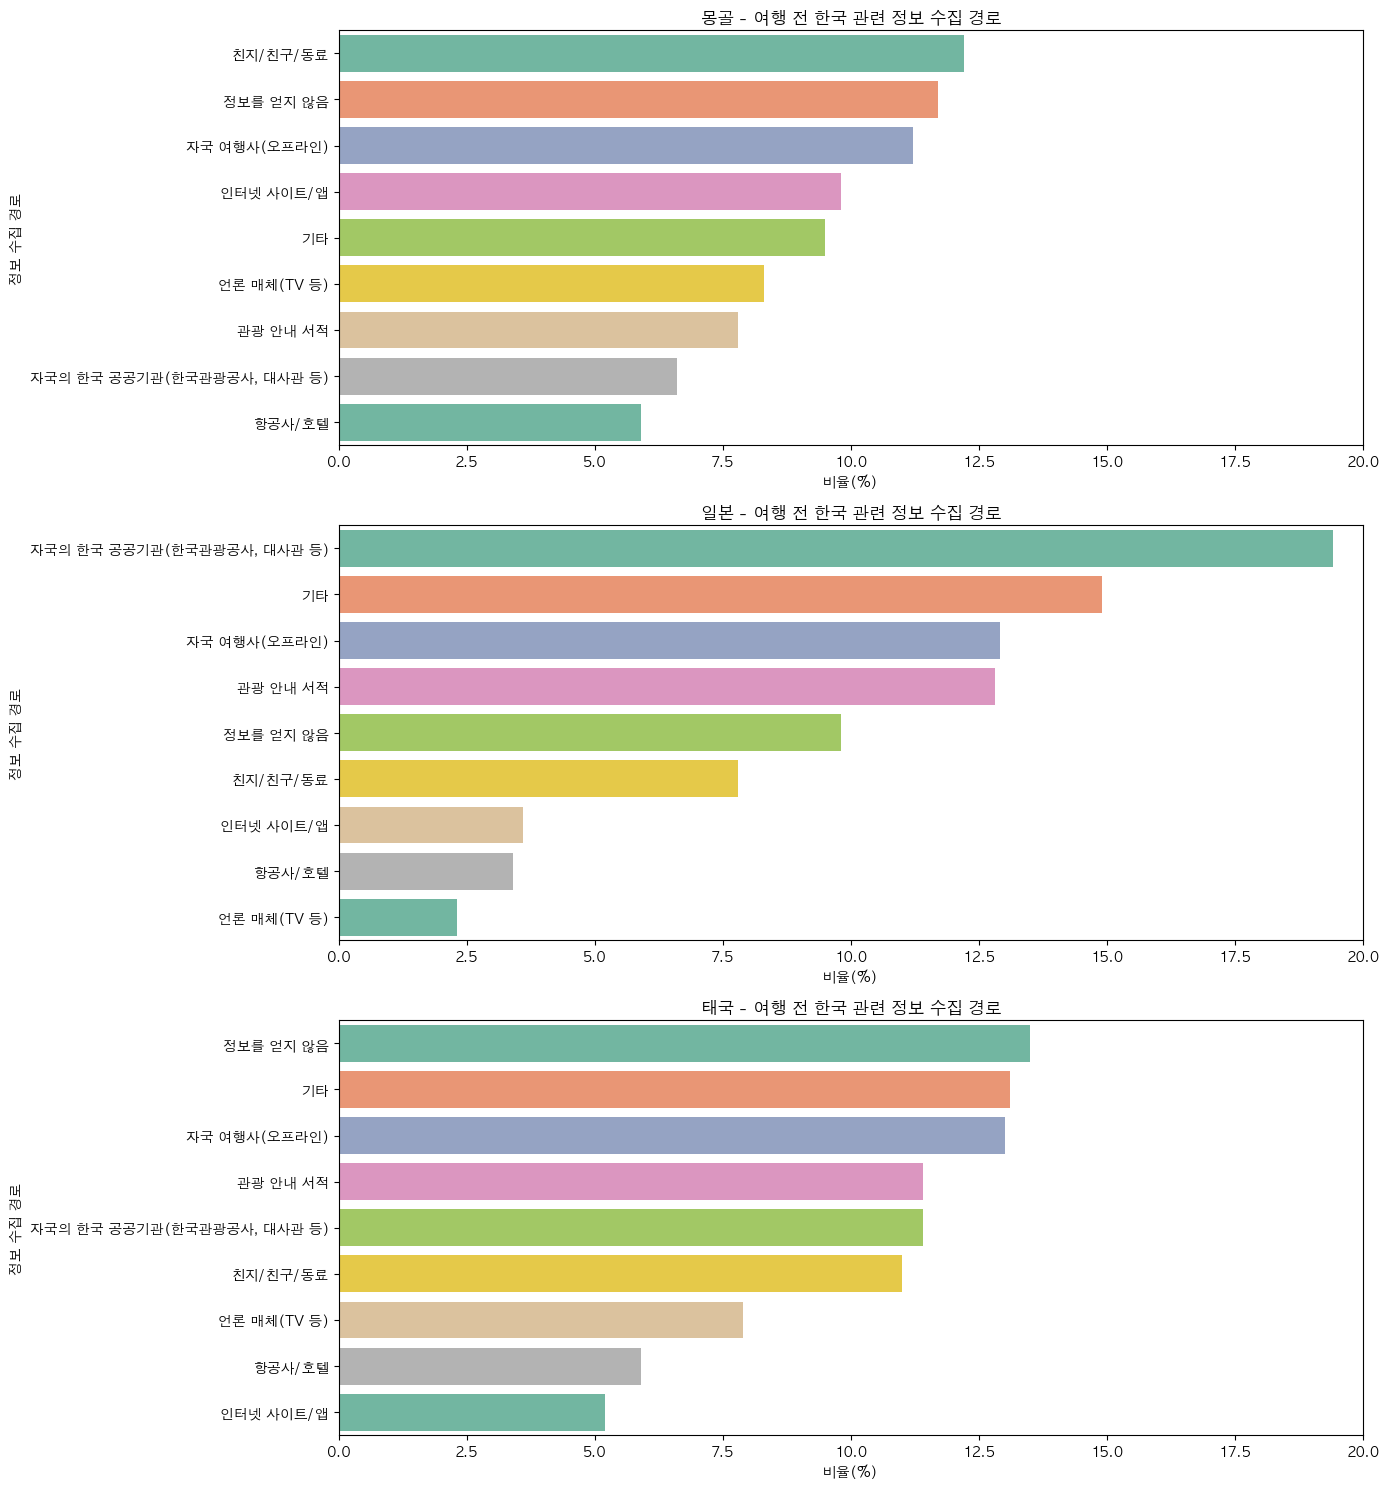

In [63]:
# 서브플롯 구성
plt.figure(figsize=(14, 5 * len(cluster4_countries)))

for i, country in enumerate(cluster4_countries):
    df_country = df_cluster4[df_cluster4["국가"] == country].copy()
    
    # 1. Q4a1~3 melt
    melted = df_country[cols + ["weight"]].melt(id_vars="weight", value_vars=cols, value_name="code").dropna(subset=["code"])
    
    # 2. Q4a_dk == 9인 경우 별도 처리
    dk_df = df_country[df_country["Q4a_dk"] == 9][["weight"]].copy()
    dk_df["code"] = 9

    # 3. 병합
    combined = pd.concat([melted[["code", "weight"]], dk_df], ignore_index=True)

    # 4. 가중합 및 비율
    weighted = combined.groupby("code")["weight"].sum().reset_index()
    total = weighted["weight"].sum()
    weighted["비율(%)"] = (weighted["weight"] / total * 100).round(1)
    weighted["정보수집경로"] = weighted["code"].map(source_map)

    # 5. 시각화
    plt.subplot(len(cluster4_countries), 1, i + 1)
    sns.barplot(data=weighted.sort_values("비율(%)", ascending=False), y="정보수집경로", x="비율(%)", palette="Set2")
    plt.title(f"{country} - 여행 전 한국 관련 정보 수집 경로")
    plt.xlabel("비율(%)")
    plt.ylabel("정보 수집 경로")
    plt.xlim(0, 20)

plt.tight_layout()
plt.show()

> 나라별 해석  

오,,, 흥미로운 결과,,,
- ***몽골***은 예상한 대로 이미 인적교류가 많아, 지인이 알려주거나 이미 알고 있는 경우가 많다.
- ***일본***이 흥미로운데, 인터넷 서칭보다도 자국에 있는 한국 공공기관에서 대부분의 여행 정보를 수집한다는 점이다. 한국관광공사의 일본지사의 경우에는 웹사이트를 봤더니, 이미 그 안에서 여행 코스, 핫플, 축제와 행사에 대한 정보가 전부 들어있었다. 즉, 이거만으로도 여행이 충분하다는 것이다. 
- ***태국***의 경우에도 KTO 태국지사는 BTS관련 패키지와 태국어 관광 홍보지를 발간하는 등의 노력을 하고있다. 무엇보다 태국의 흥미로운 점은 '정보를 얻지 않음'의 비율이 높다는 것.  

### 1) 경험 기반 방문 + 한국 친숙도
- 태국은 이미 한국의 방문 경험률과 한류 소비율이 모두 높은 국가 중 하나. 또한, k-콘텐츠를 통해 비공식적/간접적 정보를 꾸준히 접하고 있어서, "굳이 추가 정보 탐색 없이도 여행 가능하다"는 인식이 있음.
### 2) 자유여행 비중 증가
- 태국 MZ세대는 자유여행(FIT) 선호도가 높아서, 이미 알고 있는 쇼핑몰, 맛집, 유명 관광지만을 목적 중심으로 방문하는 경우가 많음. 즉, "정보를 얻지 않음"보다는 정보 수집 자체가 불필요 할수도 있음  


-> 여행하면서 즐긴 것 or 소비 형태도 볼까

---

## 5. 참여한 활동 (Q8a01~20)

In [64]:
# 참여 활동 관련 변수 리스트
cols_q8a = [f"Q8a{str(i).zfill(2)}" for i in range(1, 21)]

# 각 변수마다 고유값 확인
for i, col in enumerate(cols_q8a, start=1):
    unique_vals = df[col].dropna().unique()
    print(f"{col}: 기대값 = {i}, 실제 고유값 = {sorted(unique_vals)}")

Q8a01: 기대값 = 1, 실제 고유값 = [np.float64(1.0)]
Q8a02: 기대값 = 2, 실제 고유값 = [np.float64(2.0)]
Q8a03: 기대값 = 3, 실제 고유값 = [np.float64(3.0)]
Q8a04: 기대값 = 4, 실제 고유값 = [np.float64(4.0)]
Q8a05: 기대값 = 5, 실제 고유값 = [np.float64(5.0)]
Q8a06: 기대값 = 6, 실제 고유값 = [np.float64(6.0)]
Q8a07: 기대값 = 7, 실제 고유값 = [np.float64(7.0)]
Q8a08: 기대값 = 8, 실제 고유값 = [np.float64(8.0)]
Q8a09: 기대값 = 9, 실제 고유값 = [np.float64(9.0)]
Q8a10: 기대값 = 10, 실제 고유값 = [np.float64(10.0)]
Q8a11: 기대값 = 11, 실제 고유값 = [np.float64(11.0)]
Q8a12: 기대값 = 12, 실제 고유값 = [np.float64(12.0)]
Q8a13: 기대값 = 13, 실제 고유값 = [np.float64(13.0)]
Q8a14: 기대값 = 14, 실제 고유값 = [np.float64(14.0)]
Q8a15: 기대값 = 15, 실제 고유값 = [np.float64(15.0)]
Q8a16: 기대값 = 16, 실제 고유값 = [np.float64(16.0)]
Q8a17: 기대값 = 17, 실제 고유값 = [np.float64(17.0)]
Q8a18: 기대값 = 18, 실제 고유값 = [np.float64(18.0)]
Q8a19: 기대값 = 19, 실제 고유값 = [np.float64(19.0)]
Q8a20: 기대값 = 20, 실제 고유값 = [np.float64(20.0)]


### 이 변수는 1번~20번까지 Q8a01~20 각각 매칭하고 있음 

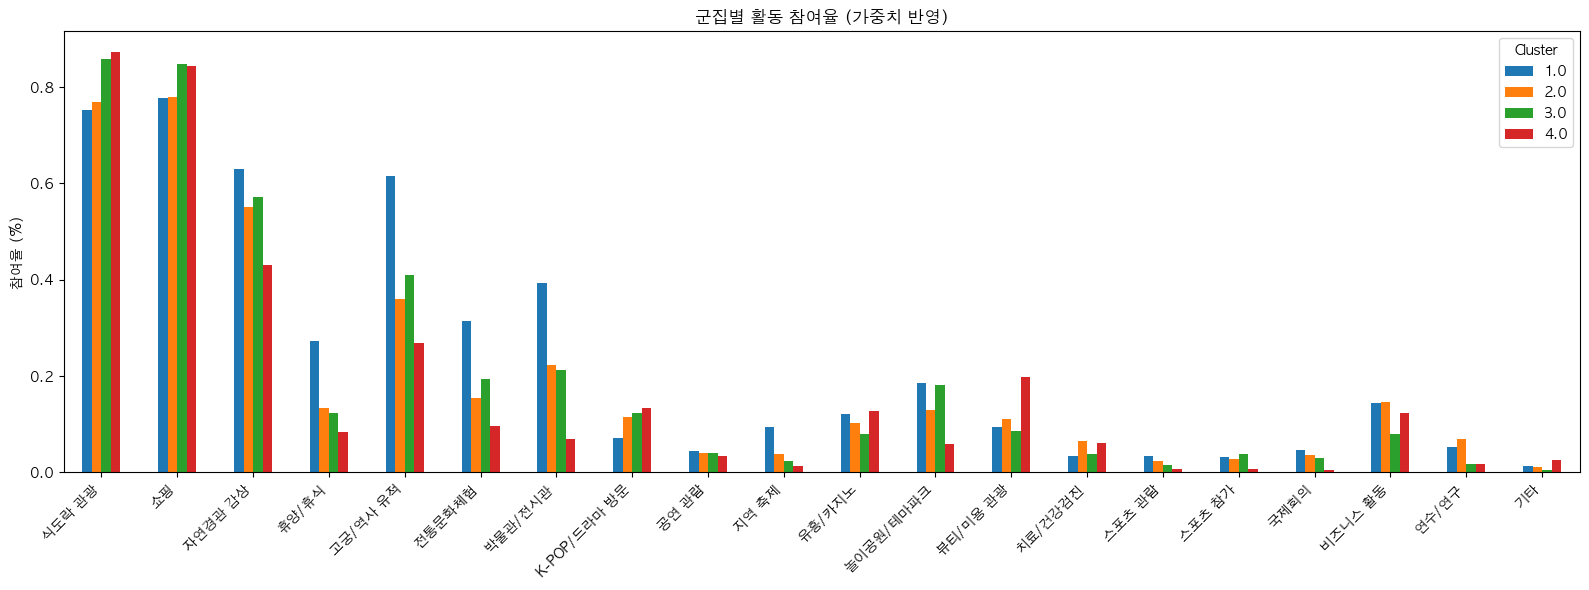

In [65]:
# 활동 변수명 리스트
q_cols = [f"Q8a{str(i).zfill(2)}" for i in range(1, 21)]

# 활동번호 1~20에 대해 더미 변수 생성
from collections import defaultdict
import pandas as pd

# 초기 빈 데이터프레임
activity_dummy = pd.DataFrame(0, index=df.index, columns=range(1, 21))

# 각 Q8a 컬럼에 대해 활동 번호 파악 후 해당 열에 1로 마킹
for col in q_cols:
    for i in range(1, 21):
        activity_dummy[i] |= (df[col] == i).astype(int)

# 열 이름 정리 (활동 이름으로 매핑)
activity_labels = {
    1: "식도락 관광", 2: "쇼핑", 3: "자연경관 감상", 4: "휴양/휴식",
    5: "고궁/역사 유적", 6: "전통문화체험", 7: "박물관/전시관",
    8: "K-POP/드라마 방문", 9: "공연 관람", 10: "지역 축제",
    11: "유흥/카지노", 12: "놀이공원/테마파크", 13: "뷰티/미용 관광",
    14: "치료/건강검진", 15: "스포츠 관람", 16: "스포츠 참가",
    17: "국제회의", 18: "비즈니스 활동", 19: "연수/연구", 20: "기타"
}
activity_dummy.columns = [activity_labels[i] for i in activity_dummy.columns]

# 가중치와 국가, 클러스터 정보 추가
activity_dummy["국가"] = df["국가"]
activity_dummy["weight"] = df["weight"]
activity_dummy["Hcluster"] = df["국가"].map(features["Hcluster"])

# 군집별 참여율 시각화
cluster_grouped = (
    activity_dummy.groupby("Hcluster")
    .apply(lambda g: (g.iloc[:, :-3].T @ g["weight"]) / g["weight"].sum())
    .T
)

cluster_grouped.plot(kind='bar', figsize=(16, 6))
plt.title("군집별 활동 참여율 (가중치 반영)")
plt.ylabel("참여율 (%)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

한눈에 보기 어려우니까 상위 5개로 다시 시각화

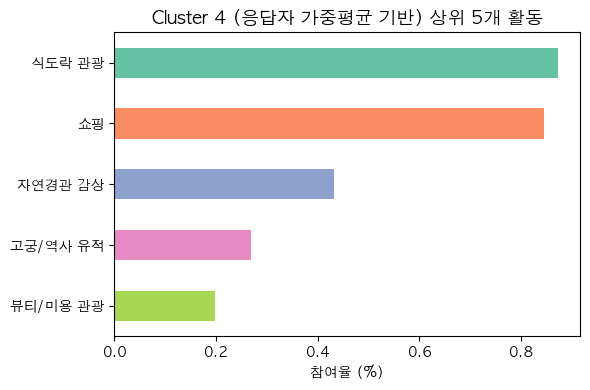

In [66]:
import matplotlib.pyplot as plt

# 활동 열만 명시적으로 지정 (혹시 순서 꼬임 방지)
activity_cols_named = [col for col in activity_dummy.columns if col not in ["국가", "weight", "Hcluster"]]

# Cluster 4 국가 필터
cluster4_countries = ['몽골', '일본', '태국']
cluster4_mask = activity_dummy["국가"].isin(cluster4_countries)

# Cluster 4 응답자 전체를 기준으로 가중평균 참여율 계산
cluster4_weighted = (
    (activity_dummy.loc[cluster4_mask, activity_cols_named].T @ activity_dummy.loc[cluster4_mask, "weight"])
    / activity_dummy.loc[cluster4_mask, "weight"].sum()
).sort_values(ascending=False)

# 상위 5개 활동 추출
top5_cluster4 = cluster4_weighted.head(5)

# 시각화
cmap = plt.get_cmap("Set2")
colors = [cmap(i) for i in range(len(top5_cluster4))]

plt.figure(figsize=(6, 4))
top5_cluster4.plot(kind="barh", color=colors)
plt.title("Cluster 4 (응답자 가중평균 기반) 상위 5개 활동", fontsize=13)
plt.xlabel("참여율 (%)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


> 군집별 비교 해석  

모든 군집의 참여한 활동이 동일하게   

1. 식도락 관광
2. 쇼핑
3. 자연경관 감상
4. 고궁/역사 유적
5. 뷰티/미용관광  

임을 확인할 수 있음. 특이한 점은 군집4만 과할 정도록 식도락 & 쇼핑에 집중되어 있음

### -> 또한, 모든 군집이 이렇다는 것은, 현재 한국 여행의 강세가 식도락, 쇼핑에 집중되어 있다는 점을 알 수 있음.

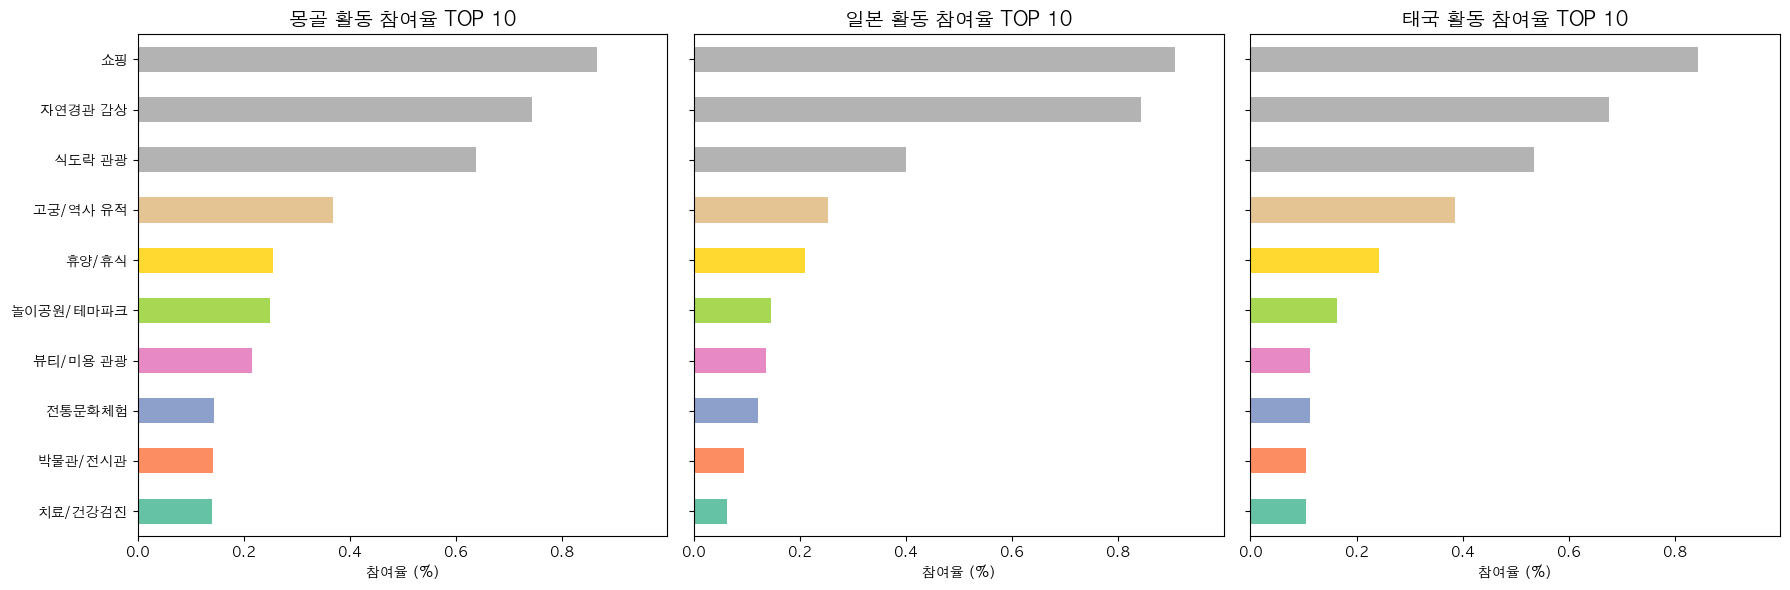

In [68]:
# 국가별 참여율 다시 계산 (weight 기준 가중 평균)
country_grouped = (
    activity_dummy[activity_dummy["국가"].isin(cluster4_countries)]
    .groupby("국가")
    .apply(lambda g: (g[activity_cols_named].T @ g["weight"]) / g["weight"].sum())
    .T
)

# 국가별 상위 10개 활동 추출
top10_by_country = {
    country: country_grouped[country].sort_values(ascending=False).head(10)
    for country in cluster4_countries
}

# 시각화
num_countries = len(top10_by_country)
fig, axes = plt.subplots(1, num_countries, figsize=(6 * num_countries, 6), sharey=True)

if num_countries == 1:
    axes = [axes]

for i, (country, top10) in enumerate(top10_by_country.items()):
    ax = axes[i]
    colors = [cmap(j) for j in range(len(top10))]
    top10.sort_values().plot(kind='barh', ax=ax, color=colors)
    ax.set_title(f"{country} 활동 참여율 TOP 10", fontsize=14)
    ax.set_xlabel("참여율 (%)")
    ax.set_xlim(0, country_grouped.max().max() * 1.1)

plt.tight_layout()
plt.show()


> 해석  

이거는 전체 비교하는거랑 국가별로 비교하는거랑 코드 상으로 구체적인 수정이 조금 들어가야 할 것 같음. 우선 확인된 것은 

- 일본 : 쇼핑과 자연경관 감상에 과하게 치우쳐져 있음
- 몽골, 태국 : 쇼핑, 자연경관 감상, 식도락 관광에 주로 모여져 있음

---

## 6. 방문지역 (Q9_2a01~17)

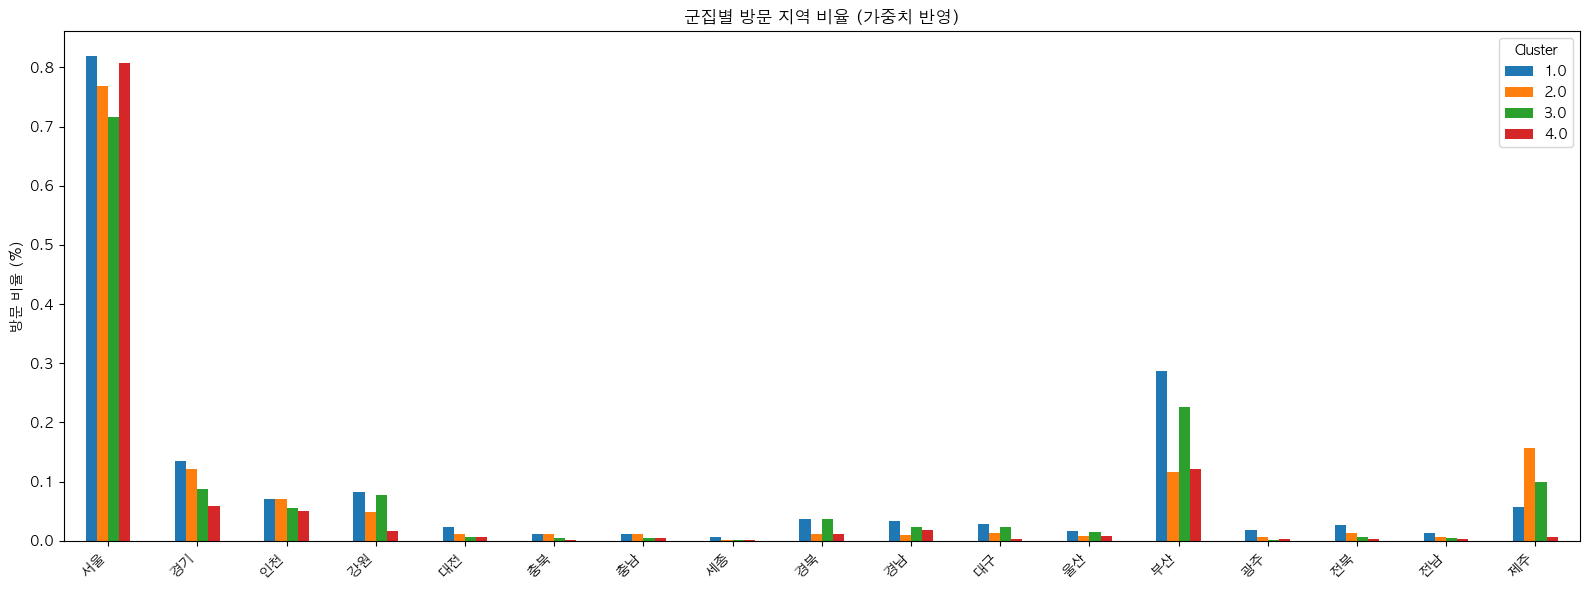

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# 지역 번호 → 이름 매핑
region_map = {
    1: "서울", 2: "경기", 3: "인천", 4: "강원", 5: "대전", 6: "충북",
    7: "충남", 8: "세종", 9: "경북", 10: "경남", 11: "대구", 12: "울산",
    13: "부산", 14: "광주", 15: "전북", 16: "전남", 17: "제주"
}

# 방문 지역 열
region_cols = [f"Q9_2a{str(i).zfill(2)}" for i in range(1, 18)]

# 더미 행렬 생성 (17개 지역)
region_dummy = pd.DataFrame(0, index=df.index, columns=range(1, 18))

# 복수 응답 처리: 각 열마다 지역번호 체크해서 1로 마킹
for col in region_cols:
    for i in range(1, 18):
        region_dummy[i] |= (df[col] == i).astype(int)

# 지역 이름으로 컬럼 변경
region_dummy.columns = [region_map[i] for i in region_dummy.columns]

# 국가 / 클러스터 / weight 붙이기
region_dummy["국가"] = df["국가"]
region_dummy["Hcluster"] = df["국가"].map(features["Hcluster"])
region_dummy["weight"] = df["weight"]

# 활동 열 (지역 이름들)
region_names = list(region_map.values())

# 군집별 방문 비율 계산 (가중치 사용)
cluster_region = (
    region_dummy.groupby("Hcluster")
    .apply(lambda g: (g[region_names].T @ g["weight"]) / g["weight"].sum())
    .T
)

# 시각화
cluster_region.plot(kind="bar", figsize=(16, 6))
plt.title("군집별 방문 지역 비율 (가중치 반영)")
plt.ylabel("방문 비율 (%)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()



> 군집별 해석  

cluster4만 보면 

- 1 : 서울이 압도적
- 2 : 부산
- 3: 경기
- 4: 인천

순위이다


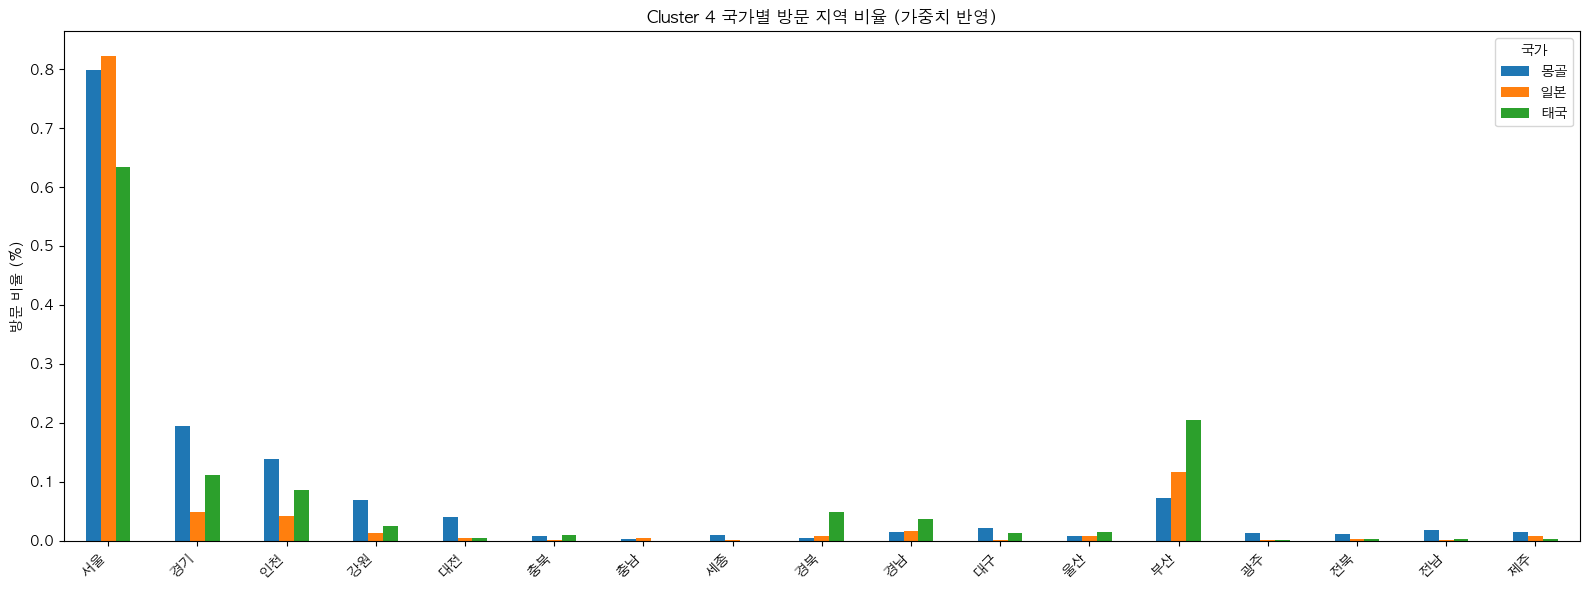

In [71]:
cluster4_countries = ['몽골', '일본', '태국']
country_region = (
    region_dummy[region_dummy["국가"].isin(cluster4_countries)]
    .groupby("국가")
    .apply(lambda g: (g[region_names].T @ g["weight"]) / g["weight"].sum())
    .T
)

# 시각화
country_region.plot(kind="bar", figsize=(16, 6))
plt.title("Cluster 4 국가별 방문 지역 비율 (가중치 반영)")
plt.ylabel("방문 비율 (%)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="국가")
plt.tight_layout()
plt.show()


> 나라별 해석  

- 몽골 : 서울 압도적 -> 경기 -> 인천 -> 부산
- 일본 : 서울 압도적 -> 부산 -> 경기 & 인천
- 태국 : 서울 압도적 -> 부산 수요가 꽤 있음 -> 경기 -> 인천

---

## 7. 총 제재기간(R일 HAP)

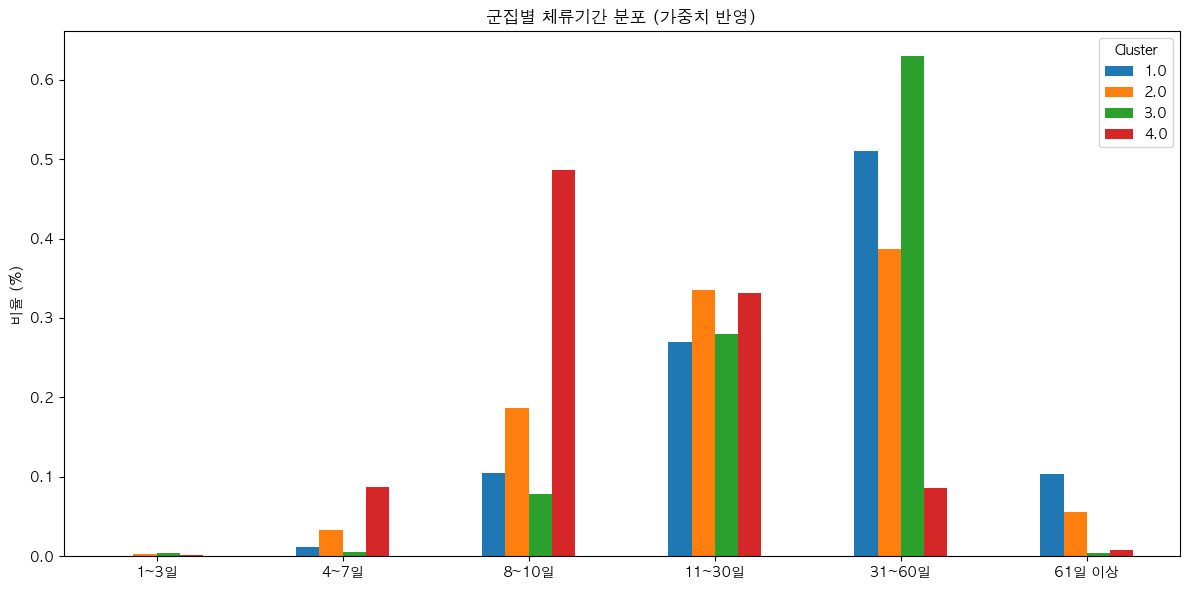

In [72]:
# 체류기간 코드 → 라벨
hap_labels = {
    1: "1~3일", 2: "4~7일", 3: "8~10일", 4: "11~30일",
    5: "31~60일", 12: "61일 이상"
}

# 유효 범위만 필터링
valid_codes = hap_labels.keys()
df_filtered = df[df["R일HAP"].isin(valid_codes)].copy()

# 군집 정보 붙이기
df_filtered["Hcluster"] = df_filtered["국가"].map(features["Hcluster"])

# 체류기간별 더미화
hap_dummy = pd.get_dummies(df_filtered["R일HAP"])
hap_dummy = hap_dummy[[c for c in hap_dummy.columns if c in hap_labels]]  # 유효 코드만
hap_dummy.columns = [hap_labels[c] for c in hap_dummy.columns]

# weight 붙이기
hap_dummy["Hcluster"] = df_filtered["Hcluster"]
hap_dummy["weight"] = df_filtered["weight"]

# 군집별 비율 계산
hap_by_cluster = (
    hap_dummy.groupby("Hcluster")
    .apply(lambda g: (g.drop(columns=["Hcluster", "weight"]).T @ g["weight"]) / g["weight"].sum())
    .T
)

# 시각화
hap_by_cluster.plot(kind='bar', figsize=(12, 6))
plt.title("군집별 체류기간 분포 (가중치 반영)")
plt.ylabel("비율 (%)")
plt.xticks(rotation=0)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


> 군집별 해석  

cluster4는
- 8~10일
- 11~30일  

이 가장 많음

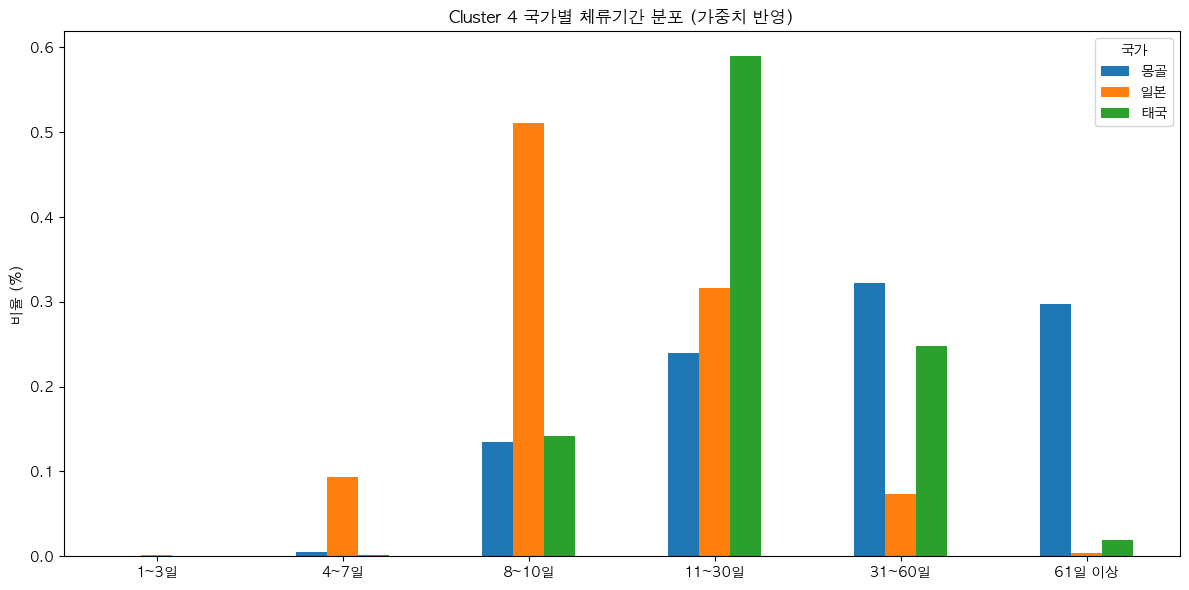

In [73]:
# Cluster 4 국가만 필터
cluster4_countries = ['몽골', '일본', '태국']
df_cluster4_hap = df_filtered[df_filtered["국가"].isin(cluster4_countries)]

# 더미화 다시 (가중치 포함)
hap_dummy_c4 = pd.get_dummies(df_cluster4_hap["R일HAP"])
hap_dummy_c4 = hap_dummy_c4[[c for c in hap_dummy_c4.columns if c in hap_labels]]
hap_dummy_c4.columns = [hap_labels[c] for c in hap_dummy_c4.columns]
hap_dummy_c4["국가"] = df_cluster4_hap["국가"]
hap_dummy_c4["weight"] = df_cluster4_hap["weight"]

# 국가별 비율 계산
hap_by_country = (
    hap_dummy_c4.groupby("국가")
    .apply(lambda g: (g.drop(columns=["국가", "weight"]).T @ g["weight"]) / g["weight"].sum())
    .T
)

# 시각화
hap_by_country.plot(kind='bar', figsize=(12, 6))
plt.title("Cluster 4 국가별 체류기간 분포 (가중치 반영)")
plt.ylabel("비율 (%)")
plt.xticks(rotation=0)
plt.legend(title="국가")
plt.tight_layout()
plt.show()


> 나라별 해석

- 몽골은 8~61일 이상 전부 고르게 분포되어 있음
- 일본은 8~10일, 11~30일이 가장 많음
- 태국은 11~30일, 31~60일이 가장 많음

---

몽골, 태국, 일본이 포함된 Cluster 4에 대해 정리한 인상:

일본: "여행 목적"이 강하고, 자유여행/체험 중심의 성숙한 시장

태국: "여행" 중심이지만 문화적/경제적 교류 요인도 일부 존재

몽골: 방문 목적에 지인 방문·교육·의료 등 실용적 요인이 강할 가능성



1. 연관규칙 분석 (Association Rule Mining) 
활용 예시

"자연경관 감상"한 사람들은 → "강원·제주 방문" + "4~7일 체류" + "K-POP 활동 참여"

적용 요소: 활동 유형, 지역 방문, 체류일수, 목적 등

2. 혼합 효과 모형 (Mixed Effects Models) – 고차원 통계 분석
개념:

국가별 이질성은 랜덤 효과,

군집별 공통 효과는 고정 효과로 설정해

군집 내부 국가별 차이를 통제하면서 군집 차이 분석 가능

적용: 체류일수/소비액을 종속변수로 설정

활용: 군집별로 체류/소비에 영향을 주는 요인 정확하게 분리

👉 정책 수립/예산 배분 모델로 적합

3. 시뮬레이션 기반 정책 실험 (ABM 또는 가상시나리오 모델링)
**Agent-Based Modeling (ABM)**으로

일본 관광객의 체류일수 증가 → 소비 증가?

지방 방문 인센티브 제공 시 관광 분산 효과는?

활용 예시:

체류일수가 길어지면 어떤 활동에 참여할 확률이 높아지는지

가상 시나리오로 정책 효과 시뮬레이션


